In [2]:
import os
import clip
import torch
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms

from constants import CHEXPERT_LABELS
from data.loaders import CxrDataLoader

In [3]:
CHECKPOINT_PATH = "./output"

args = argparse.Namespace(
    dataset_name='mimic-cxr',
    batch_size=64,
    num_workers=0,
    max_seq_length=248,
    use_minio=False
)

In [4]:
# model_path = os.path.join(CHECKPOINT_PATH, "best_128_5e-05_original_22000_0.855.pt")
model_path = os.path.join(CHECKPOINT_PATH, "clip_cxr_model.pt")
model, preprocess = clip.load(model_path, load_checkpoint=True)

input_resolution = model.visual.input_resolution
context_length = model.context_length
extended_context_length = model.extended_context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Original context length:", context_length)
print("Extended context length:", extended_context_length)
print("Vocab size:", vocab_size)

[Warning] Unexpected keys in state_dict: ['positional_embedding_res']
Model parameters: 151,772,943
Input resolution: 224
Original context length: 248
Extended context length: 248
Vocab size: 49408


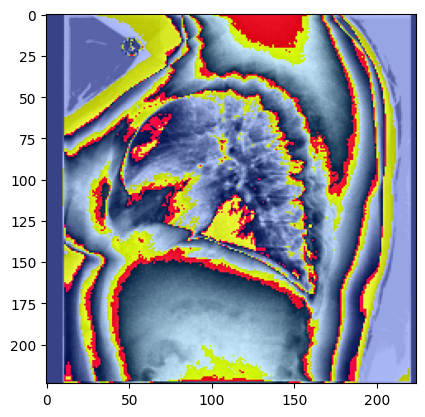

In [13]:
test_loader = CxrDataLoader(args, split='train', transform=preprocess)

test_loader_iter = iter(test_loader)
entry = next(test_loader_iter)

image = transforms.ToPILImage()(entry["image"][0])
image = image.convert("RGB")

plt.imshow(image, cmap="gray")

In [7]:
def select_random_sample_from_loader(loader):
    """
    Selects a single sample from the DataLoader while preserving preprocessing logic.
    """
    for batch in loader:
        batch_size = batch['image'].size(0)
        idx = random.randint(0, batch_size - 1)
        return {key: batch[key][idx] for key in batch}

In [9]:
test_loader = CxrDataLoader(args, split='test', transform=preprocess)
entry = select_random_sample_from_loader(test_loader)

image_tensor = entry["image"].unsqueeze(0)
report = entry["report"]
labels = entry["labels"]
print(report)

all_other_classes = CHEXPERT_LABELS.copy()
for label, classname in zip(labels, CHEXPERT_LABELS):
    print(f"{classname}: {label}")

    prompts = [classname, f"No {classname}"]
    text_tokens = clip.tokenize(prompts)

    outputs = model(image_tensor, text_tokens)
    logits_per_image, logits_per_text = outputs['logits_per_image'], outputs['logits_per_text']

    probs = torch.softmax(logits_per_image, dim=-1).detach().cpu().numpy().flatten()

    print(f"Probability for '{classname}': {probs[0]:.4f}")
    print(f"Probability for 'No {classname}': {probs[1]:.4f}")

    image_features = outputs["image_features"] / (outputs["image_features"].norm(dim=-1, keepdim=True) + 1e-8)
    text_features = outputs["text_features"] / (outputs["text_features"].norm(dim=-1, keepdim=True) + 1e-8)

    logit_scale = model.logit_scale.exp().clamp(max=100)
    similarity = (logit_scale * image_features @ text_features.T).detach().cpu().numpy().flatten()
    print(f"Cosine Similarity ('{classname}' ↔ image): {similarity[0]:.4f}")
    print(f"Cosine Similarity ('No {classname}' ↔ image): {similarity[1]:.4f}")

    distractor = random.choice([c for c in all_other_classes if c != classname])
    distractor_prompt = clip.tokenize([distractor])
    distractor_feat = model.encode_text(distractor_prompt)
    distractor_feat = distractor_feat / (distractor_feat.norm(dim=-1, keepdim=True) + 1e-8)

    sim_distractor = (logit_scale * image_features @ distractor_feat.T).item()
    print(f"Cosine Similarity (Non-matching '{distractor}' ↔ image): {sim_distractor:.4f}")

Comparison is made with prior study ___.
 
 Moderate cardiomegaly is stable.  Mild-to-moderate pulmonary edema has
 improved.  Right lower lobe aeration has improved.  Left lower lobe opacities
 have minimally improved, consistent with atelectasis, edema and pleural
 effusion. Enlargement of the pulmonary arteries is again noted.  ET tube is in
 standard position.  NG tube tip is out of view below the diaphragm. Left IJ
 catheter tip is in the upper-to-mid SVC. nan
Atelectasis: 1.0
Probability for 'Atelectasis': 0.4186
Probability for 'No Atelectasis': 0.5814
Cosine Similarity ('Atelectasis' ↔ image): 21.5387
Cosine Similarity ('No Atelectasis' ↔ image): 21.8672
Cosine Similarity (Non-matching 'Support Devices' ↔ image): 27.5224
Cardiomegaly: 1.0
Probability for 'Cardiomegaly': 0.4021
Probability for 'No Cardiomegaly': 0.5979
Cosine Similarity ('Cardiomegaly' ↔ image): 19.9644
Cosine Similarity ('No Cardiomegaly' ↔ image): 20.3610
Cosine Similarity (Non-matching 'Atelectasis' ↔ image):

In [13]:
def test_prompt_similarity(model, image_tensor, prompts):
    text_tokens = clip.tokenize(prompts, truncate=True, extended_context=True)

    with torch.no_grad():
        outputs = model(image_tensor, text_tokens)
        logits = outputs["logits_per_image"]
        probs = torch.softmax(logits, dim=-1).cpu().numpy().flatten()

        image_features = outputs["image_features"] / (outputs["image_features"].norm(dim=-1, keepdim=True) + 1e-8)
        text_features = outputs["text_features"] / (outputs["text_features"].norm(dim=-1, keepdim=True) + 1e-8)

        logit_scale = model.logit_scale.exp().clamp(max=100)
        similarities = (logit_scale * image_features @ text_features.T).detach().cpu().numpy().flatten()

    print("\n--- Prompt Similarity Evaluation ---")
    for prompt, sim, prob in zip(prompts, similarities, probs):
        print(f"Prompt: {prompt}\n  Cosine similarity: {sim:.4f}\n  Softmax prob:      {prob:.4f}\n")

In [15]:
test_loader = CxrDataLoader(args, split='test', transform=preprocess)
entry = select_random_sample_from_loader(test_loader)

image_tensor = entry["image"].unsqueeze(0)
labels = entry["labels"]
print(", ".join(f"{label}: {value}" for label, value in zip(CHEXPERT_LABELS, labels)))

prompts = [
    "A chest X-ray showing pneumonia",
    "A chest X-ray with no abnormalities",
    "A dog playing fetch",
    "CT scan of the abdomen",
    "No finding"
]

test_prompt_similarity(model, image_tensor, prompts)

Atelectasis: -1.0, Cardiomegaly: 1.0, Consolidation: 0.0, Edema: 0.0, Enlarged Cardiomediastinum: 1.0, Fracture: 0.0, Lung Lesion: 0.0, Lung Opacity: 1.0, No Finding: 0.0, Pleural Effusion: -1.0, Pleural Other: 0.0, Pneumonia: -1.0, Pneumothorax: 0.0, Support Devices: 1.0

--- Prompt Similarity Evaluation ---
Prompt: A chest X-ray showing pneumonia
  Cosine similarity: 23.4758
  Softmax prob:      0.4142

Prompt: A chest X-ray with no abnormalities
  Cosine similarity: 22.6353
  Softmax prob:      0.1787

Prompt: A dog playing fetch
  Cosine similarity: 16.4779
  Softmax prob:      0.0004

Prompt: CT scan of the abdomen
  Cosine similarity: 23.3690
  Softmax prob:      0.3723

Prompt: No finding
  Cosine similarity: 20.9861
  Softmax prob:      0.0344



## Zero-shot classification

In [14]:
# List of 14 CheXpert classes as prompts
prompts = [f"A chest X-ray showing {label}" for label in CHEXPERT_LABELS]
print(", ".join(f"{label}: {value}" for label, value in zip(CHEXPERT_LABELS, labels)))

# Tokenize all prompts at once
text_tokens = clip.tokenize(prompts)
text_features = model.encode_text(text_tokens)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# Compute image features
image_tensor = entry["image"].unsqueeze(0)
image_features, _ = model.encode_image(image_tensor)
image_features = image_features / image_features.norm(dim=-1, keepdim=True)

# Similarity + scaling + softmax
logit_scale = model.logit_scale.exp().clamp(max=100)
logits = logit_scale * image_features @ text_features.T
probs = torch.softmax(logits, dim=-1).detach().cpu().numpy().flatten()

# Show top-1 prediction
top_index = probs.argmax()
print(f"Top prediction: {CHEXPERT_LABELS[top_index]} (prob: {probs[top_index]:.4f})")

# Show all probabilities
for label, prob in zip(CHEXPERT_LABELS, probs):
    print(f"{label}: {prob:.4f}")

Atelectasis: 1.0, Cardiomegaly: 1.0, Consolidation: 0.0, Edema: 1.0, Enlarged Cardiomediastinum: 0.0, Fracture: 0.0, Lung Lesion: 0.0, Lung Opacity: 1.0, No Finding: 0.0, Pleural Effusion: 1.0, Pleural Other: 0.0, Pneumonia: 0.0, Pneumothorax: 0.0, Support Devices: 1.0
Top prediction: Support Devices (prob: 0.5768)
Atelectasis: 0.0059
Cardiomegaly: 0.0006
Consolidation: 0.0396
Edema: 0.1570
Enlarged Cardiomediastinum: 0.0096
Fracture: 0.0045
Lung Lesion: 0.0274
Lung Opacity: 0.0543
No Finding: 0.0066
Pleural Effusion: 0.0879
Pleural Other: 0.0155
Pneumonia: 0.0048
Pneumothorax: 0.0095
Support Devices: 0.5768


Query report: Question of posterior 10 rib fracture, correlate with XXXX tenderness.
Query labels: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Candidate report: Age-indeterminate contour deformity of the right lateral 8th rib, if findings localize to this region, suspect acute fracture. Very low lung volumes, central and basilar opacities most suggestive of atelectasis. Heart size near top normal limits for technique, left infraclavicular cardiac XXXX generator with right atrial and right ventricular leads, sternotomy XXXX, CABG clips. Evaluation for pleural fluid limited but no large pleural effusion seen. No pleural line of pneumothorax.
Candidate labels: tensor([ 1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
Matching pair similarity: [[27.400936]]
Non-matching pair similarity: [[23.49522]]


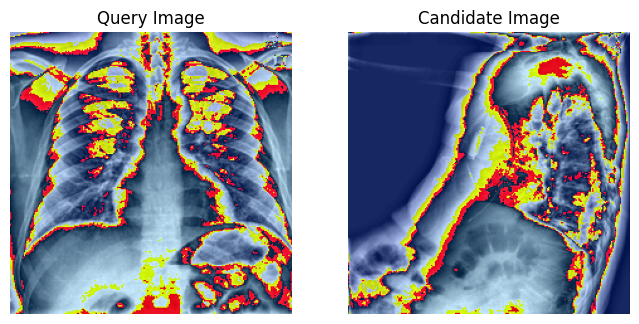

In [28]:
def select_non_matching_sample_by_labels(loader, query_labels):
    """
    Iterates over the loader to find a sample whose label tensor differs from the query sample's labels.

    Args:
        loader: A data loader that yields batches containing the key "labels".
        query_labels (torch.Tensor): The label tensor for the query sample.

    Returns:
        A sample dictionary from the loader that has different labels than the query, or None if not found.
    """
    for batch in loader:
        batch_size = len(batch["uid"])
        for i in range(batch_size):
            candidate_labels = batch["labels"][i]
            if not torch.equal(candidate_labels, query_labels):
                return { key: batch[key][i] for key in batch }
    return None

# Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader_iter = iter(test_loader)
query_entry = next(test_loader_iter)
query_image_tensor = query_entry["image"][0].unsqueeze(0).to(device)
query_report = query_entry["report"][0]
query_labels = query_entry["labels"][0]

print("Query report:", query_report)
print("Query labels:", query_labels)

non_matching_entry = select_non_matching_sample_by_labels(test_loader, query_labels)
if non_matching_entry is None:
    print("No non-matching sample found!")
else:
    candidate_image_tensor = non_matching_entry["image"].unsqueeze(0).to(device)
    candidate_report = non_matching_entry["report"]
    candidate_labels = non_matching_entry["labels"]
    print("Candidate report:", candidate_report)
    print("Candidate labels:", candidate_labels)

    # Encode query image and text
    proj_query, _ = model.encode_image(query_image_tensor)
    text_query = model.encode_text(clip.tokenize(query_report, extended_context=True).to(device)).float()

    proj_query /= proj_query.norm(dim=-1, keepdim=True)
    text_query /= text_query.norm(dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp().clamp(max=100)

    # Matching pair similarity (query image with its own text)
    sim_matching = (logit_scale * (text_query @ proj_query.T)).detach().cpu().numpy()

    # Encode candidate image (non-matching)
    proj_candidate, _ = model.encode_image(candidate_image_tensor)
    proj_candidate /= proj_candidate.norm(dim=-1, keepdim=True)

    sim_nonmatching = (logit_scale * (text_query @ proj_candidate.T)).detach().cpu().numpy()

    print("Matching pair similarity:", sim_matching)
    print("Non-matching pair similarity:", sim_nonmatching)

    # Optionally visualize the images
    from torchvision.transforms import ToPILImage
    import matplotlib.pyplot as plt

    query_img = ToPILImage()(query_entry["image"][0])
    candidate_img = ToPILImage()(non_matching_entry["image"])

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(candidate_img)
    plt.title("Candidate Image")
    plt.axis("off")
    plt.show()

In [5]:
def compute_clip_class_probs(model, image_tensor, class_labels):
    prompts = [f"A chest X-ray showing {label}" for label in class_labels]
    text_tokens = clip.tokenize(prompts, extended_context=True).to(device)

    with torch.no_grad():
        image_features, _ = model.encode_image(image_tensor.to(device))
        text_features = model.encode_text(text_tokens)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = model.logit_scale.exp().clamp(max=100)
        logits = logit_scale * image_features @ text_features.T
        probs = torch.softmax(logits, dim=-1)

    return probs.cpu().numpy().flatten()

Report: There are chronic changes in both lungs with appearance of emphysema. No acute airspace disease. No pulmonary edema. No XXXX of pleural effusions. Findings are grossly unchanged compared with prior chest CT from XXXX.
Atelectasis: 0.0396 | Cardiomegaly: 0.0056 | Consolidation: 0.0601 | Edema: 0.0671 | Enlarged Cardiomediastinum: 0.0053 | Fracture: 0.0123 | Lung Lesion: 0.1523 | Lung Opacity: 0.1902 | No Finding: 0.2010 | Pleural Effusion: 0.0422 | Pleural Other: 0.1554 | Pneumonia: 0.0209 | Pneumothorax: 0.0054 | Support Devices: 0.0426


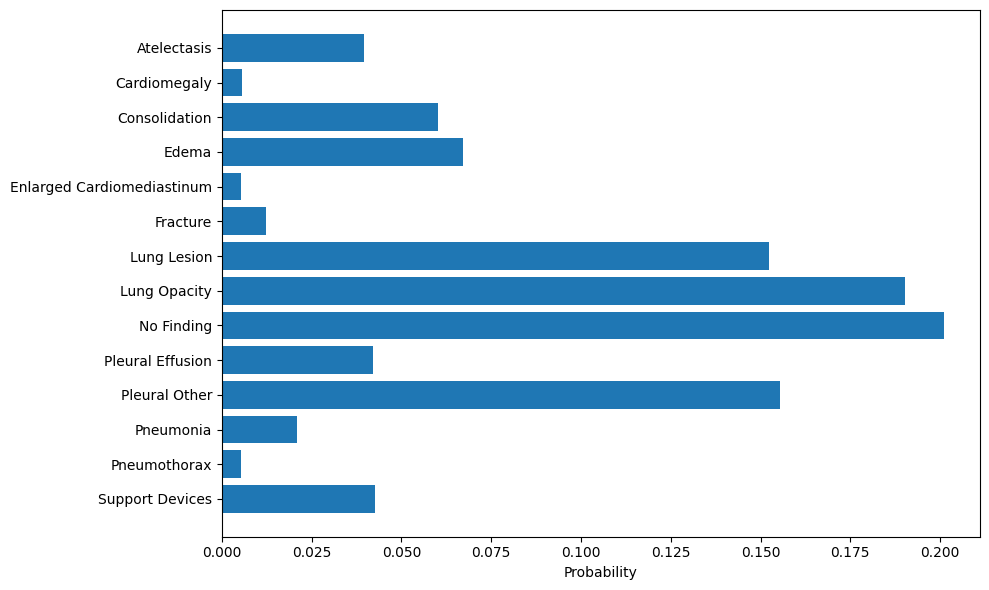

Report: No acute cardiopulmonary findings
Atelectasis: 0.0704 | Cardiomegaly: 0.0246 | Consolidation: 0.0515 | Edema: 0.0175 | Enlarged Cardiomediastinum: 0.0126 | Fracture: 0.0060 | Lung Lesion: 0.0419 | Lung Opacity: 0.0487 | No Finding: 0.2645 | Pleural Effusion: 0.0522 | Pleural Other: 0.0615 | Pneumonia: 0.1054 | Pneumothorax: 0.0013 | Support Devices: 0.2418


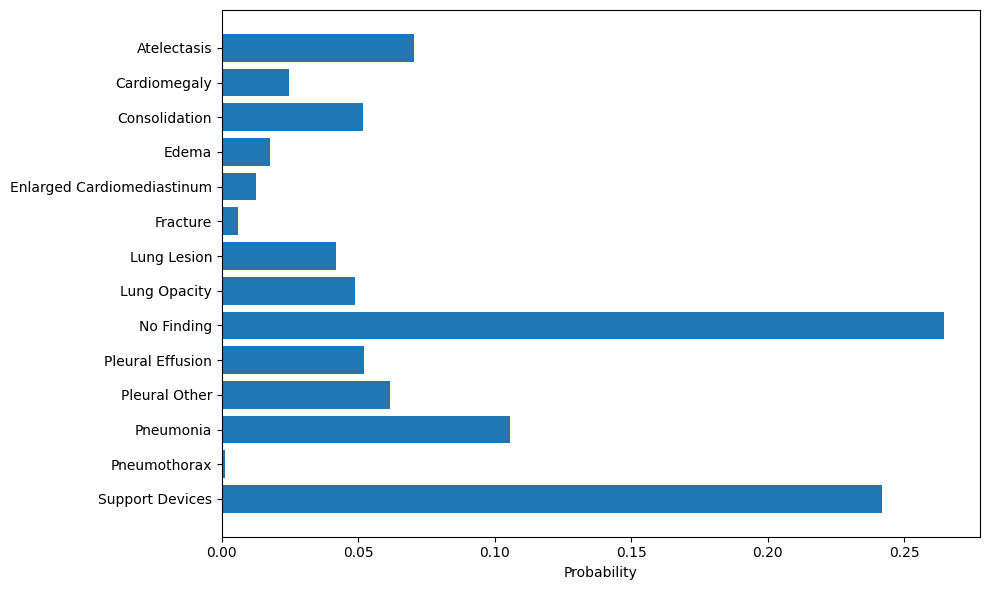

Report: No acute disease.
Atelectasis: 0.1447 | Cardiomegaly: 0.0038 | Consolidation: 0.0245 | Edema: 0.0184 | Enlarged Cardiomediastinum: 0.0034 | Fracture: 0.0039 | Lung Lesion: 0.0466 | Lung Opacity: 0.0678 | No Finding: 0.3723 | Pleural Effusion: 0.0301 | Pleural Other: 0.0598 | Pneumonia: 0.0458 | Pneumothorax: 0.0052 | Support Devices: 0.1737


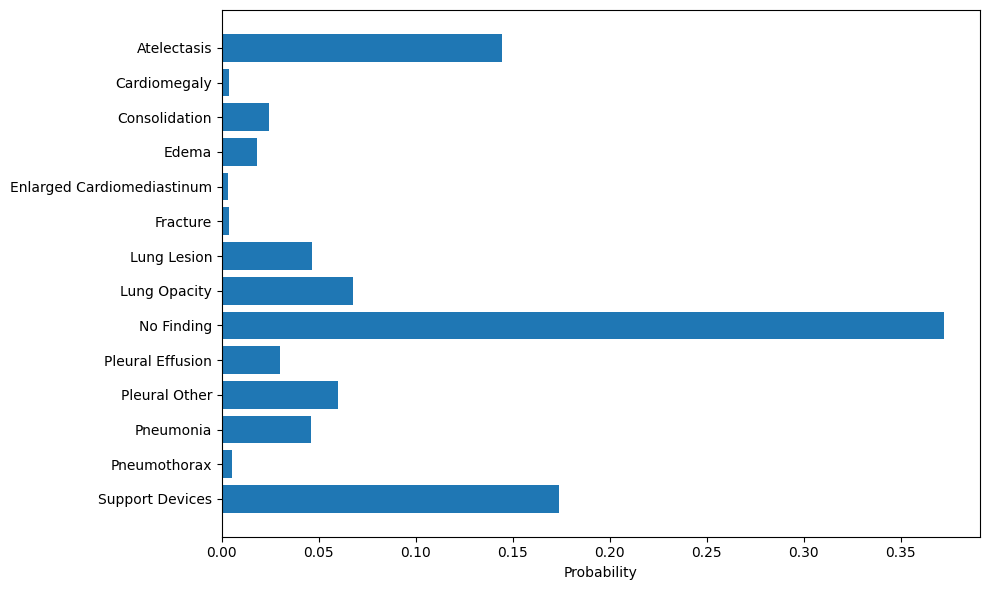

Report: 1. Minimally displaced fracture involving the lateral right 7th rib, XXXX acute. There is and associated small right pleural effusion and right basilar atelectasis. 2. Questionable anterior XXXX cortical disruption seen XXXX on lateral view. XXXX would be needed to evaluate this. 3. XXXX left-sided pleural effusion
Atelectasis: 0.0683 | Cardiomegaly: 0.0026 | Consolidation: 0.0409 | Edema: 0.0402 | Enlarged Cardiomediastinum: 0.0010 | Fracture: 0.0141 | Lung Lesion: 0.1472 | Lung Opacity: 0.0858 | No Finding: 0.2535 | Pleural Effusion: 0.0706 | Pleural Other: 0.1654 | Pneumonia: 0.0102 | Pneumothorax: 0.0054 | Support Devices: 0.0949


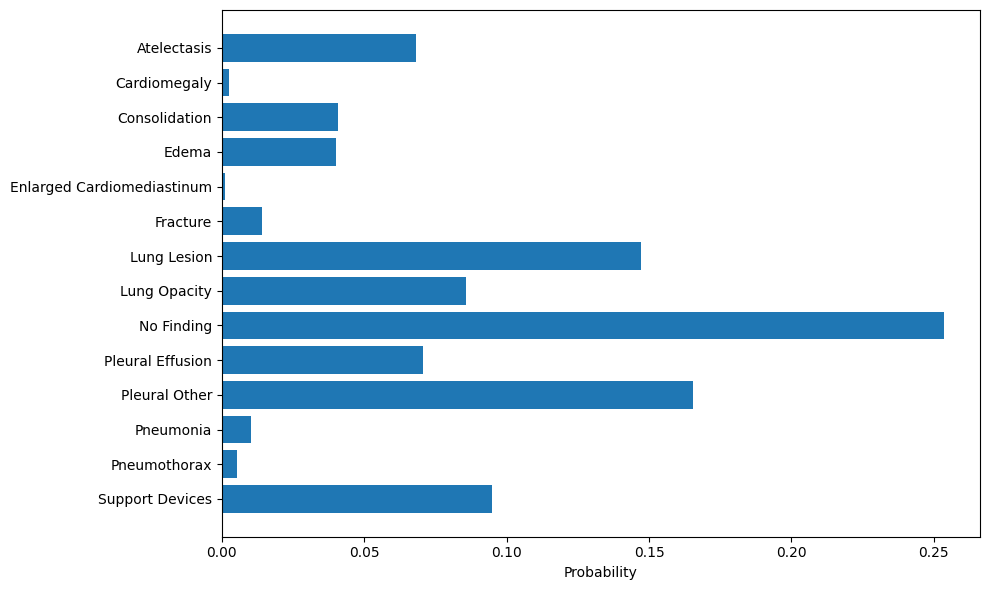

Report: No acute abnormality. .
Atelectasis: 0.0947 | Cardiomegaly: 0.0034 | Consolidation: 0.0577 | Edema: 0.0401 | Enlarged Cardiomediastinum: 0.0052 | Fracture: 0.0055 | Lung Lesion: 0.0311 | Lung Opacity: 0.0551 | No Finding: 0.3762 | Pleural Effusion: 0.0318 | Pleural Other: 0.0682 | Pneumonia: 0.0365 | Pneumothorax: 0.0187 | Support Devices: 0.1759


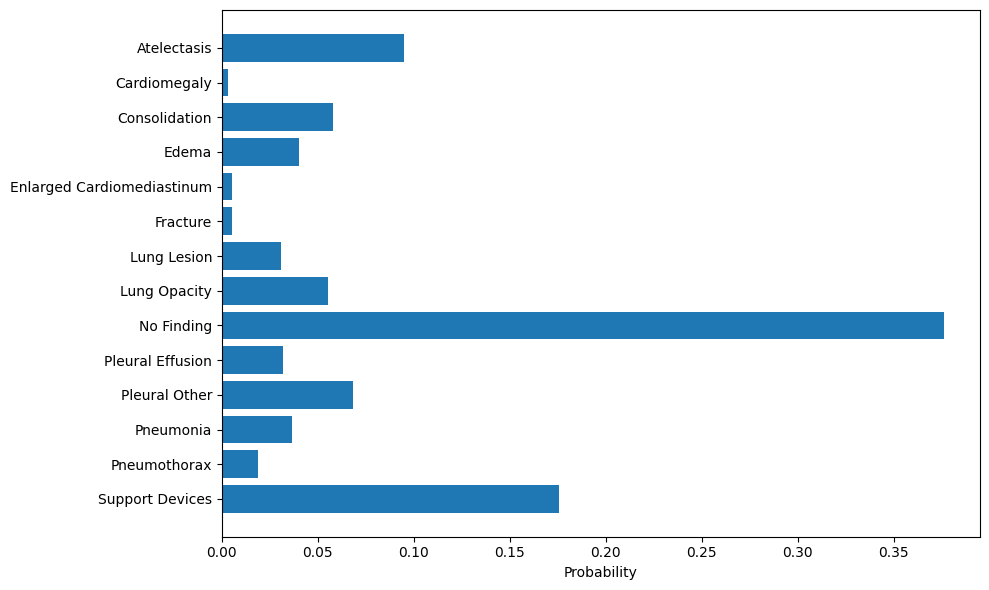

Report: The lungs are hypoinflated. There is focal airspace disease in the right lung base concerning for pneumonia or aspiration. There is minimal airspace disease in the left lung base, XXXX atelectasis. There is no pneumothorax or large pleural effusion. Heart size is normal.
Atelectasis: 0.1584 | Cardiomegaly: 0.1297 | Consolidation: 0.0429 | Edema: 0.0173 | Enlarged Cardiomediastinum: 0.0458 | Fracture: 0.0149 | Lung Lesion: 0.1094 | Lung Opacity: 0.0394 | No Finding: 0.1181 | Pleural Effusion: 0.0172 | Pleural Other: 0.0293 | Pneumonia: 0.0634 | Pneumothorax: 0.0016 | Support Devices: 0.2126


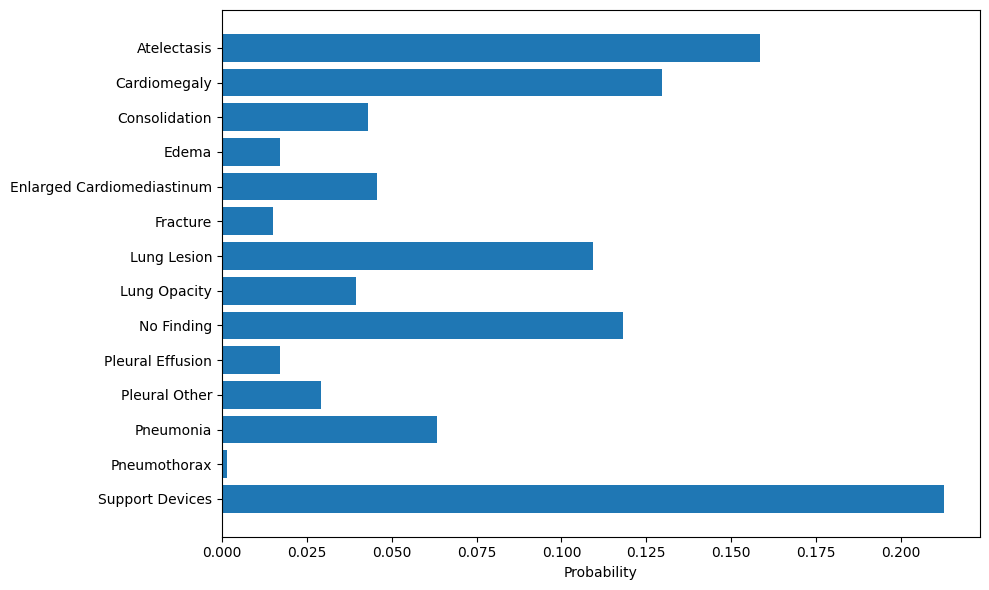

Report: 1. Vague density in right XXXX, XXXX related to scapular tip and superimposed ribs. Consider oblique images to exclude true nodule. 2. No acute cardiopulmonary abnormality.
Atelectasis: 0.0902 | Cardiomegaly: 0.0351 | Consolidation: 0.0535 | Edema: 0.0437 | Enlarged Cardiomediastinum: 0.0195 | Fracture: 0.0087 | Lung Lesion: 0.0530 | Lung Opacity: 0.0532 | No Finding: 0.3373 | Pleural Effusion: 0.0191 | Pleural Other: 0.0593 | Pneumonia: 0.0597 | Pneumothorax: 0.0035 | Support Devices: 0.1641


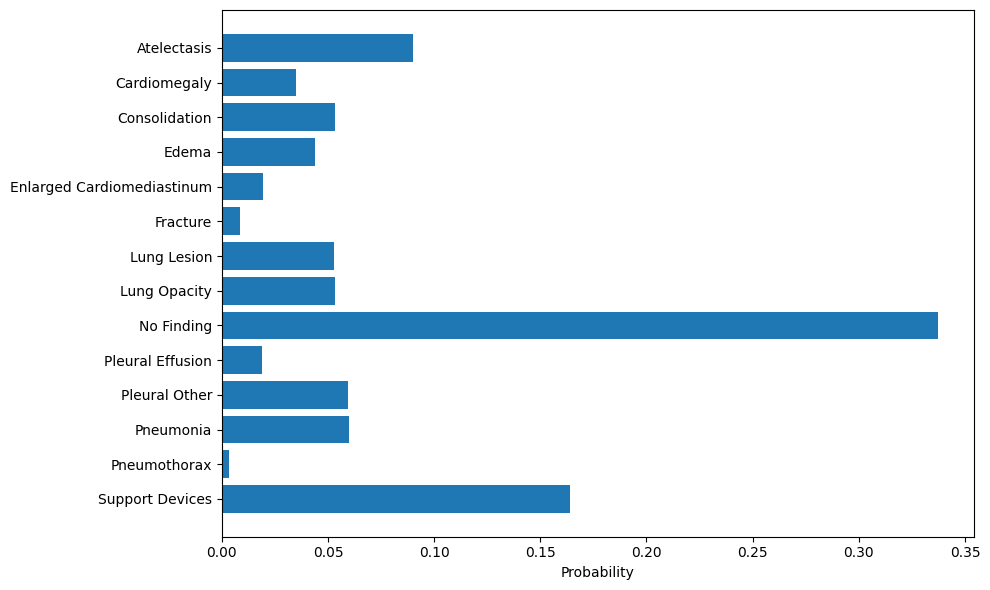

Report: Heart size is normal and lungs are clear.
Atelectasis: 0.1252 | Cardiomegaly: 0.0299 | Consolidation: 0.0334 | Edema: 0.0467 | Enlarged Cardiomediastinum: 0.0130 | Fracture: 0.0099 | Lung Lesion: 0.0417 | Lung Opacity: 0.0572 | No Finding: 0.3109 | Pleural Effusion: 0.0273 | Pleural Other: 0.0667 | Pneumonia: 0.0509 | Pneumothorax: 0.0018 | Support Devices: 0.1854


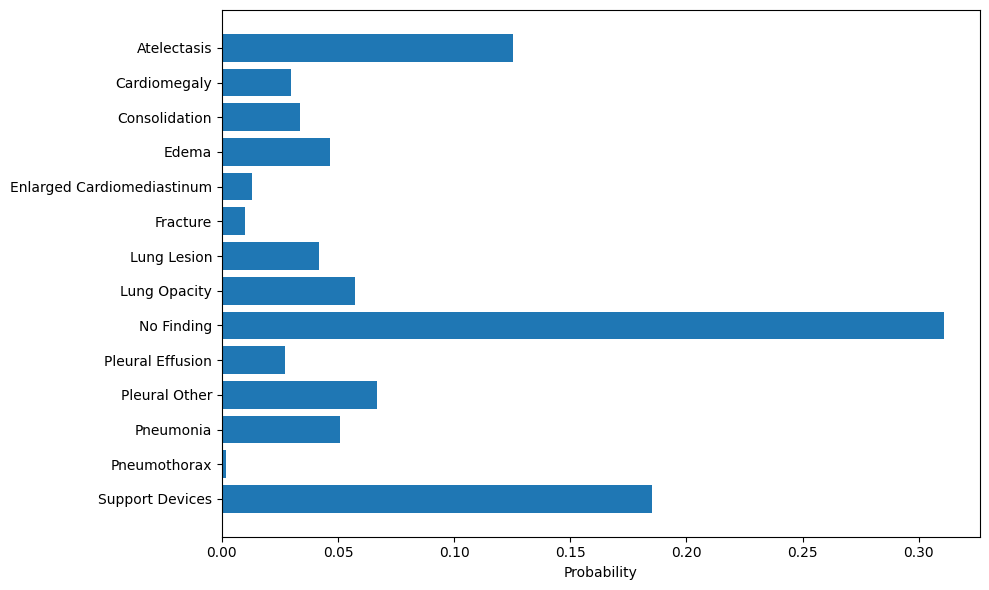

Report: No active disease.
Atelectasis: 0.1026 | Cardiomegaly: 0.0573 | Consolidation: 0.0443 | Edema: 0.0712 | Enlarged Cardiomediastinum: 0.0348 | Fracture: 0.0136 | Lung Lesion: 0.0521 | Lung Opacity: 0.0363 | No Finding: 0.2911 | Pleural Effusion: 0.0382 | Pleural Other: 0.0970 | Pneumonia: 0.0270 | Pneumothorax: 0.0031 | Support Devices: 0.1313


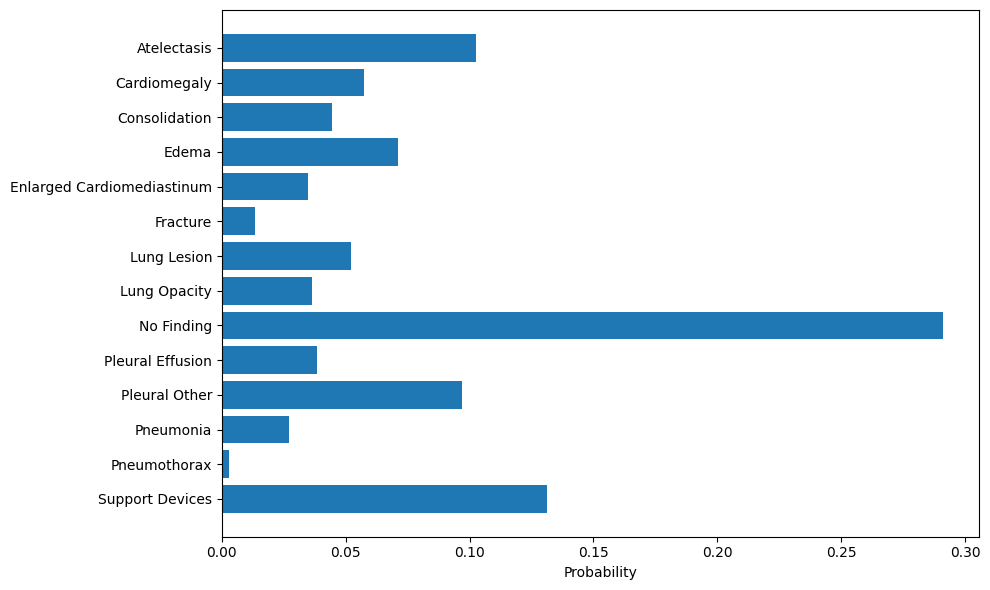

Report: 1. No evidence of active disease.
Atelectasis: 0.2017 | Cardiomegaly: 0.0612 | Consolidation: 0.0469 | Edema: 0.0430 | Enlarged Cardiomediastinum: 0.0360 | Fracture: 0.0129 | Lung Lesion: 0.0213 | Lung Opacity: 0.0272 | No Finding: 0.2281 | Pleural Effusion: 0.0251 | Pleural Other: 0.0411 | Pneumonia: 0.0290 | Pneumothorax: 0.0022 | Support Devices: 0.2242


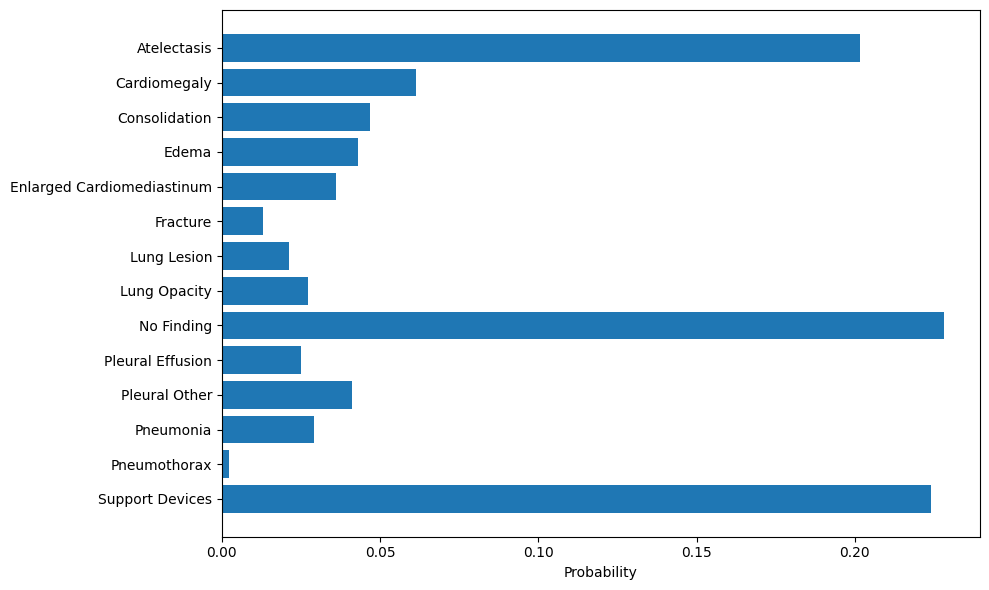

In [13]:
data_loader = CxrDataLoader(args, split='train', transform=preprocess)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_samples = 10
for i, entry in enumerate(data_loader):
    if i >= num_samples:
        break

    image_tensor = entry["image"][0].unsqueeze(0).to(device)
    report = entry["report"][0]
    labels = entry["labels"][0]

    probs = compute_clip_class_probs(model, image_tensor, CHEXPERT_LABELS)
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(CHEXPERT_LABELS))
    plt.barh(y_pos, probs, align='center')
    plt.yticks(y_pos, CHEXPERT_LABELS)
    plt.xlabel('Probability')
    print("Report:", report)
    print(" | ".join([f"{label}: {prob:.4f}" for prob, label in zip(probs, CHEXPERT_LABELS)]))
    plt.gca().invert_yaxis()  # highest prob on top
    plt.tight_layout()
    plt.show()